In [ ]:
#default_exp experiments

In [ ]:
%load_ext autoreload
%autoreload 2
from pwc_gabor_layer.core import GaborLayer, SigmaRegularizer
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First load mnist 

Data processing as in the tensorflow datasets tutorial, this is just for an example. And more specifically for fixing issues with backpropagtion!

In [ ]:
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, 
                         as_supervised=True, with_info=True)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Some MNIST examples.

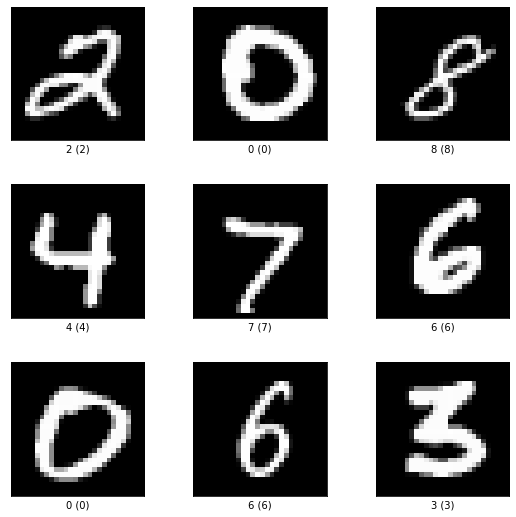

In [ ]:
# tfds.show_examples does not go with supervised features
ds_viz, viz_info = tfds.load('mnist', split='test', shuffle_files=True, 
                         as_supervised=False, with_info=True)

tfds.show_examples(ds_viz, viz_info);

# Some settings for later
ds_viz = ds_viz.batch(16)
ds_viz = ds_viz.cache()

## Apply kernel to MNIST

In [ ]:
GL = GaborLayer(filters=2, kernel_size=(7, 7), orientations=8, use_alphas=False, activation=None)
GL.build([None, 28, 28, 1])

Get a single element of MNIST dataset

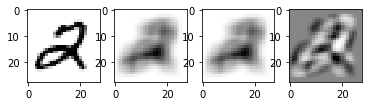

In [ ]:
one_batch = np.stack(list(ds_viz))[0]['image']

blub = GL.call(tf.cast(one_batch[:1, :, :, :]/255, tf.float32))

n1 = 6; n2 = n1 + 1

plt.subplot(141)
plt.imshow(one_batch[0,:,:,0], cmap='Greys')
plt.subplot(142)
plt.imshow(blub[0, :, :, n1], cmap='Greys')
plt.subplot(143)
plt.imshow(blub[0, :, :, n2], cmap='Greys')
plt.subplot(144)
plt.imshow(blub[0, :, :, n1]-blub[0, :, :, n2], cmap='Greys')

In [ ]:
test_gl =  GaborLayer(filters=16, kernel_size=(7,7), orientations=8, 
                      activation='relu', use_bias=False, use_alphas=False, learn_orientations=False,
                     sigma_regularizer=SigmaRegularizer(factor=0.5))
model = keras.models.Sequential([
                        keras.layers.Input([28, 28, 1]),
                        test_gl,
                         keras.layers.Flatten(),
                        keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gabor_layer_5 (GaborLayer)   (None, 28, 28, 128)       170       
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1003530   
Total params: 1,003,700
Trainable params: 1,003,594
Non-trainable params: 106
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

In [ ]:
model.fit(ds_train, validation_data=ds_test)

469/469 [==============================] - 78s 167ms/step - loss: 136.6447 - accuracy: 0.7341 - val_loss: 43.7199 - val_accuracy: 0.8780


In [ ]:
kernel = tf.transpose(GL.kernel, [1, 2, 3, 0])

kernel = tf.repeat(kernel, 2, axis=2)

In [ ]:
x = np.stack(list(ds_viz))[0]['image']
y = np.stack(list(ds_viz))[0]['label']

In [ ]:
def get_gradient(model, x, y):
    #taping the gradients
    with tf.GradientTape() as tape:
        #model predictions
        preds = model(x)
        #getting the loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, preds)

    grads = tape.gradient(loss, model.trainable_variables)
    return grads

grads = get_gradient(model, x, y)

In [ ]:
for g,v in list(zip(grads, model.trainable_variables)):
    print(v.name)
    print(g)
    #print(tf.math.reduce_mean(g).numpy())
    print('-'*50)

gabor_layer_5/gammas:0
tf.Tensor(
[[[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[-0.]]]]



 [[[[ 0.]]]]



 [[[[-0.]]]]



 [[[[ 0.]]]]



 [[[[-0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[-0.]]]]



 [[[[-0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]], shape=(16, 1, 1, 1, 1), dtype=float32)
--------------------------------------------------
gabor_layer_5/psis:0
tf.Tensor(
[[[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]



 [[[[0.]]]]], shape=(16, 1, 1, 1, 1), dtype=float32)
--------------------------------------------------
gabor_layer_5/sigmas:0
tf.Tensor(
[[[[[-0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[-0.]]]]



 [[[[-0.]]]]



 [[[[-0.]]]]



 [[[[-0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[ 0.]]]]



 [[[[-0.]]]]



 [[[[-0.]]]]



 [[[[-0.]]]]



 [

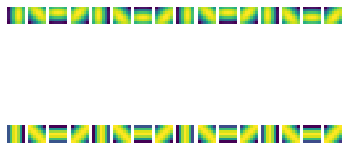

In [ ]:
fig, axes = plt.subplots(2, 16)

for n, ax in enumerate(axes.flatten()[:16]):
    ax.imshow(test_gl.kernel[n,:,:,0])
    ax.axis('off')
    
for n, ax in enumerate(axes.flatten()[16:]):
    ax.imshow(GL.kernel[n,:,:,0])
    ax.axis('off')